# Understanding personal protective behaviours and opportunities for interventions:
## Results from a multi-method investigation of cross-sectional data
#### Kaisa Sauro, James Twose, Gjalt-Jorn Peters, Matti Heino & Nelli Hankonen

## approach used here: _SuStaIn (Subtype and Stage Inference)_

- Young, A. L., Marinescu, R. V., Oxtoby, N. P., Bocchetta, M., Yong, K., Firth, N. C., ... & Alexander, D. C. (2018). Uncovering the heterogeneity and temporal complexity of neurodegenerative diseases with Subtype and Stage Inference. _Nature communications, 9_(1), 1-16.
https://www.nature.com/articles/s41467-018-05892-0

- Aksman, L. M., Wijeratne, P. A., Oxtoby, N. P., Eshaghi, A., Shand, C., Altmann, A., ... & Young, A. L. (2021). pySuStaIn: a Python implementation of the Subtype and Stage Inference algorithm. _SoftwareX, 16,_ 100811.
https://www.sciencedirect.com/science/article/pii/S2352711021001096?via%3Dihub

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from jmspack.utils import apply_scaling

from sklearn.metrics import mean_squared_error
# import shap
# shap.initjs()

In [2]:
import pySuStaIn as ps

In [3]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

### Virtual Environments and Packages

In [4]:
session_info.show(req_file_name="notebook-requirements.txt",
      write_req_file=False) #add write_req_file=True to function to get requirements.txt file of packages used

### Read in data, show info and data head

In [5]:
df = pd.read_csv("data/shield_gjames_21-09-20_prepped.csv").drop("Unnamed: 0", axis=1)

In [6]:
df.head()

,id,sampling_weight,demographic_gender,demographic_age,demographic_4_areas,demographic_8_areas,demographic_higher_education,behaviour_indoors_nonhouseholders,behaviour_close_contact,behaviour_quarantined,...,intention_public_transport_recoded,intention_indoor_meeting_recoded,intention_restaurant_recoded,intention_pa_recoded,intention_composite,behaviour_indoors_nonhouseholders_recoded,behaviour_unmasked_recoded,behavior_composite,behavior_composite_recoded,intention_behavior_composite
0,1,2.060959,2,60+,2,7,0,2,5,2,...,0,0,0,0,0,1.000000,0.000000,0.000000,0.000000,0.000000
1,2,1.784139,2,40-49,1,1,1,3,3,2,...,0,1,1,1,3,0.785714,0.214286,0.168367,0.841837,1.920918
2,3,1.204000,1,60+,1,2,1,4,4,2,...,0,0,0,0,0,0.500000,0.214286,0.107143,0.535714,0.267857
3,4,2.232220,1,60+,2,6,0,4,3,2,...,0,2,0,2,4,0.500000,0.500000,0.250000,1.250000,2.625000
4,5,1.627940,2,18-29,1,3,0,6,3,2,...,0,2,0,0,2,0.000000,0.214286,0.000000,0.000000,1.000000


In [7]:
sdt_columns = df.filter(regex="sdt").columns.tolist()

In [8]:
drop_sdt = True
if drop_sdt:
    df=df.drop(sdt_columns, axis=1)

In [9]:
df.shape

(2272, 87)

### Specify the feature list, grouping variable, and specify the grouping variable as a categorical variable

In [10]:
target = "intention_behavior_composite"

In [11]:
df[target] = (df[target] - 10) * -1

In [12]:
features_list = df.filter(regex="^automaticity|attitude|^norms|^risk|^effective").columns.tolist()

In [13]:
meta_columns = ['Original position', 'Variable name', 'Label',
       'Item english translation ', 'Label short', 'Type', 'New variable name',
       'variable name helper',
       'Of primary interest as a predictor (i.e. feature)?', 'English lo-anchor',
       'English hi-anchor']

In [14]:
sheet_id = "1BEX4W8XRGnuDk4Asa_pdKij3EIZBvhSPqHxFrDjM07k"
sheet_name = "Variable_names"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
meta_df = pd.read_csv(url).loc[:, meta_columns]

In [15]:
meta_list = df.filter(regex="^automaticity|attitude|^norms|^risk|^effective|^behaviour|^intention").columns.tolist()

In [16]:
pd.set_option("display.max_colwidth", 350)
pd.set_option('display.expand_frame_repr', True)
meta_df.loc[meta_df["New variable name"].isin(meta_list), ["Item english translation ", "Label short", "New variable name"]] #use Label Short instead of Item english translation for relabelling the axes

,Item english translation,Label short,New variable name
12,"How often in the last 7 days have you been indoors with people outside your household so that it is not related to obligations? For example, meeting friends, visiting hobbies, non-essential shopping, or other activities that are not required for your work or other duties.\n",Being indoors with people outside household,behaviour_indoors_nonhouseholders
13,"In the last 7 days, have you been in close contact with people outside your household? Direct contact means spending more than one minute less than two meters away from another person or touching (e.g., shaking hands) outdoors or indoors.",Close contact,behaviour_close_contact
14,"Are you currently in quarantine or isolation due to an official instruction or order? (For example, because you are waiting for a corona test, have returned from abroad or been exposed to a coronavirus)",Quarantine or isolation,behaviour_quarantined
15,How often in the last 7 days were you in your free time without a mask indoors with people you don’t live with?,Without a mask indoors with people outside household,behaviour_unmasked
24,"If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Grocery store or other store\n",Intention to wear a mask grocery store or other store,intention_store
25,"If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Bus, train or other means of public transport",Intention to wear a mask public transport,intention_public_transport
26,"If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Meeting people outside your household indoors",Intention to wear a mask meeting people outside indoors,intention_indoor_meeting
27,"If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Cafe, restaurant or bar indoors","Intention to wear a mask cafe, restaurant or bar",intention_restaurant
28,"If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Indoor exercise",Intention to wear a mask indoor exercise,intention_pa
29,"Taking a mask with you to a store or public transport, for example, has already become automatic for some and is done without thinking. For others, taking a mask with them is not automatic at all, but requires conscious thinking and effort.",Is taking a mask with you automatic for you?,automaticity_carry_mask


In [17]:
pd.set_option("display.max_colwidth", 100)

## EDA on the target
Check the amount of samples in the target

### SuStaIn is an unsupervised learning algorithm so the target is not used in fitting or prediction it will be used to see differences based on identified groups

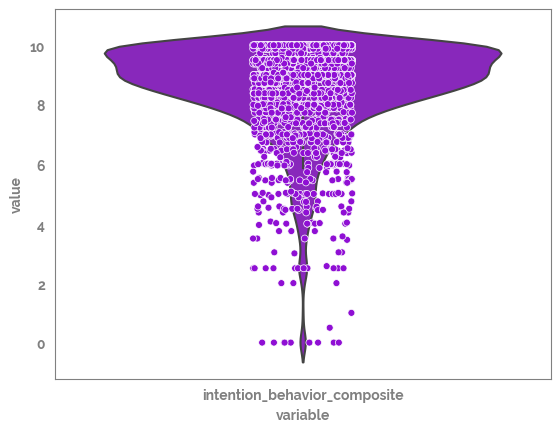

In [18]:
_ = sns.violinplot(data=df[[target]].melt(), 
                    x="variable", 
                    y="value"
               )
_ = sns.stripplot(data=df[[target]].melt(), 
                    x="variable", 
                    y="value",
                  edgecolor='white',
                  linewidth=0.5
               )

In [19]:
pd.crosstab(df["demographic_gender"], df["demographic_age"])

demographic_age,18-29,30-39,40-49,50-59,60+
demographic_gender,,,,,
1,114,169,187,168,337
2,281,185,229,211,391


In [20]:
target_df = df[target]
target_df.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
intention_behavior_composite,2272.0,8.582428,1.524704,-0.0,8.017857,8.964286,9.5,10.0


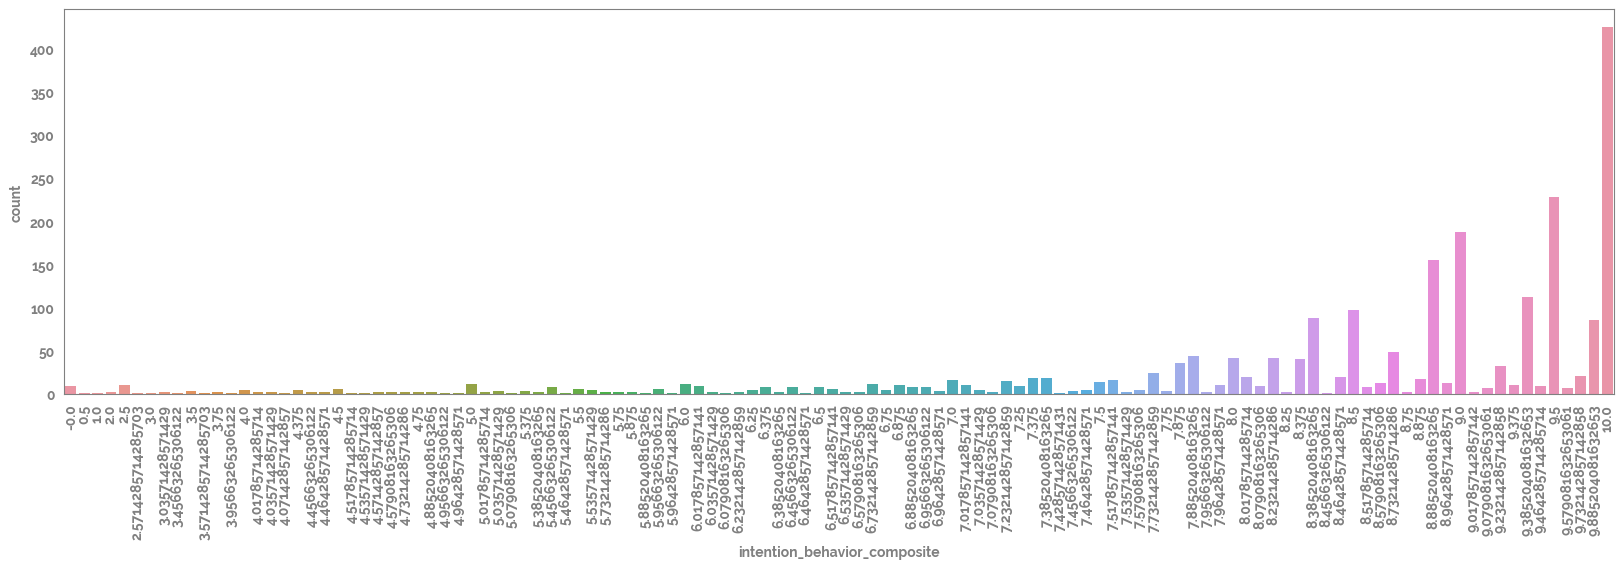

In [21]:
_ = plt.figure(figsize=(20, 5))
_ = sns.countplot(x=target_df)
_ = plt.xticks(rotation=90)

## Force all feature variables to categorical data

In [22]:
df[features_list] = df[features_list].astype("category")

In [23]:
df = (df[["demographic_age", "demographic_higher_education"] + features_list + [target]])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   demographic_age                   2272 non-null   object  
 1   demographic_higher_education      2272 non-null   int64   
 2   automaticity_carry_mask           2272 non-null   category
 3   automaticity_put_on_mask          2272 non-null   category
 4   inst_attitude_protects_self       2272 non-null   category
 5   inst_attitude_protects_others     2272 non-null   category
 6   inst_attitude_sense_of_community  2272 non-null   category
 7   inst_attitude_enough_oxygen       2272 non-null   category
 8   inst_attitude_no_needless_waste   2272 non-null   category
 9   norms_family_friends              2272 non-null   category
 10  norms_risk_groups                 2272 non-null   category
 11  norms_officials                   2272 non-null   catego

In [25]:
display(df[target].value_counts().head().to_frame()), df.shape[0], df[target].value_counts().head().sum()

,intention_behavior_composite
10.000000,424
9.500000,228
9.000000,187
8.885204,155
9.385204,112


(None, 2272, 1106)

# Prepare SuStaIn inputs

## Choosing the settings
The SuStaIn algorithm requires the following inputs.

### data
The data you want to run SuStaIn on, of size M subjects by N biomarkers. This needs to be z-scored in the way described in the previous section.

### Z_vals
This is the set of z-scores you want to include for each biomarker. The more z-scores you use the longer the SuStaIn algorithm will take to run. Z_vals has size N biomarkers by Z z-scores. If you have more z-scores for some biomarkers than others you can simply leave zeros at the end of biomarker rows with fewer z-scores.

### Z_max
The maximum z-score reached at the end of the progression, with size N biomarkers by 1. I'd suggest choosing a value around the 95th percentile of your data but you can experiment with different values. I typically choose an integer for interpretability but you don't have to.

### SuStaInLabels
The names of the biomarkers you are using, for plotting purposes.

### N_startpoints
The number of startpoints to use when fitting the subtypes hierarchichally. I'd suggest using 25.

### N_S_max
The maximum number of subtypes to fit. I'd suggest starting with a lower number - maybe three - and then increasing that if you're getting a significantly better fit with the maximum number of subtypes. You can judge this roughly from the MCMC plot. To properly evaluate the optimal number of subtypes you need to run cross-validation.

### N_iterations_MCMC
The number of iterations for the MCMC sampling of the uncertainty in the progression pattern. I'd recommend using 1x10^5 or 1x10^6.

### output_folder
Choose an output folder for the results.

### dataset_name
Name the results files outputted by SuStaIn.

### use_parellel_startpoints
Boolean for whether or not to parallelize the startpoints.

### Additional note
There are approximate and exact versions of the computation of the data likelihood for the linear z-score model. Currently the python version only supports the approximate version. If you want to use the exact version please see the Matlab version at https://github.com/ucl-pond/SuStaInMatlab.

In [26]:
zdata=(df
       .dropna() # SuStaIn cannot handle missing values
       .loc[:, features_list]
       .pipe(apply_scaling, method="Standard")
       )

Now that we've z-scored our data, let's start prepping the many SuStaIn inputs

In [27]:
zdata.sample(n=5)

,automaticity_carry_mask,automaticity_put_on_mask,inst_attitude_protects_self,inst_attitude_protects_others,inst_attitude_sense_of_community,inst_attitude_enough_oxygen,inst_attitude_no_needless_waste,norms_family_friends,norms_risk_groups,norms_officials,...,effective_means_masks,effective_means_distance,effective_means_ventilation,risk_likely_contagion,risk_contagion_absent_protection,risk_severity,risk_fear_spread,risk_fear_contagion_self,risk_fear_contagion_others,risk_fear_restrictions
229,0.245144,0.180972,-0.275634,0.667294,1.430336,0.752298,0.964805,-1.243253,0.536606,0.460641,...,0.215470,0.030018,-1.665714,-1.042926,0.606327,-0.231389,-1.992283,-1.179499,-0.193000,-1.272281
465,0.245144,0.180972,-1.637024,-0.143017,0.801154,0.752298,1.464245,0.700328,0.536606,0.460641,...,0.215470,0.030018,-0.347302,-0.246714,0.606327,-0.809099,0.291505,0.420076,0.410989,-0.215574
601,-0.316882,0.180972,-0.956329,-1.763640,-1.086391,-0.807210,-0.533512,-1.243253,-1.081402,-1.403254,...,0.836722,0.755552,-0.347302,-1.042926,0.029695,0.924031,0.862451,0.953268,0.410989,0.841133
351,0.807171,0.758454,1.085757,0.667294,1.430336,1.272134,1.464245,0.700328,0.536606,0.460641,...,0.836722,0.755552,0.971111,-1.042926,-1.700203,1.501740,1.433398,1.486460,1.014979,1.897841
975,-0.878909,-0.396511,1.085757,0.667294,-0.457209,0.752298,-0.034073,-1.243253,-0.272398,0.460641,...,0.836722,0.755552,-1.006508,-1.042926,-1.700203,1.501740,-0.279442,-0.113115,-0.796990,1.369487


In [28]:
zdata.shape

(2272, 27)

In [29]:
N = len(features_list)         # number of features

SuStaInLabels=features_list
Z_vals = np.array([[1,2,3]]*N)     # Z-scores for each feature
Z_max  = np.array([5]*N)           # maximum z-score
print(Z_vals)

[[1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]]


In [30]:
# Input the settings for z-score SuStaIn
# To make the tutorial run faster I've set 
# N_startpoints = 10 and N_iterations_MCMC = int(1e4)
# I recommend using N_startpoints = 25 and 
# N_iterations_MCMC = int(1e5) or int(1e6) in general though

N_startpoints = 10
N_S_max = 2
N_iterations_MCMC = int(1e4)
output_folder = os.path.join(os.getcwd(), 'SuStaIn_output')
dataset_name = 'SuStaIn_output'

# Initiate the SuStaIn object
sustain_input = ps.ZscoreSustain(
                              zdata.values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              use_parallel_startpoints=True,
                              seed=42
                              )

# make the output directory if it's not already created
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

### Fitting the algorithm

In [31]:
(samples_sequence,
samples_f,
ml_subtype,
prob_ml_subtype,
ml_stage,
prob_ml_stage,
prob_subtype_stage)  = sustain_input.run_sustain_algorithm()

Found pickle file: /Users/jamestwose/Coding/multi-method-protective-behaviour/SuStaIn_output/pickle_files/SuStaIn_output_subtype0.pickle. Using pickled variables for 0 subtype.
Failed to find pickle file: /Users/jamestwose/Coding/multi-method-protective-behaviour/SuStaIn_output/pickle_files/SuStaIn_output_subtype1.pickle. Running SuStaIn model for 1 subtype.
Splitting cluster 1 of 1
 + Resolving 2 cluster problem


KeyboardInterrupt: 

# Evaluate subtypes

Here, we'll plot the log likelihood across MCMC samples, across each subtype. This will give us at least a basic sense of what how many subtypes we should consider looking at

In [ ]:
def read_LL_df(file_name, column_name):
    return pd.DataFrame(pd.read_pickle(file_name)[column_name], columns=[column_name])

In [ ]:
LL_df = pd.concat([read_LL_df(f"{output_folder}/pickle_files/{dataset_name}_subtype{x}.pickle", 
                      column_name="samples_likelihood") for x in range(N_S_max)], 
          axis=1)

LL_df.columns=[f"Log Likelihood {x}" for x in range(N_S_max)]

LL_df.head()

In [ ]:
_ = sns.lineplot(data=LL_df.reset_index().melt(id_vars="index"),
                 x="index",
                 y="value",
                 hue="variable")
_ = plt.xlabel('MCMC samples')
_ = plt.ylabel('Log likelihood')
_ = plt.title('MCMC trace')
_ = sns.despine()

_ = sns.displot(data=LL_df)
_ = plt.xlabel('Log likelihood')  
_ = plt.ylabel('Number of samples')  
_ = plt.title('Histograms of model likelihood')

### Let's plot positional variance diagrams to interpret the subtype progressions

In [ ]:
# Let's plot positional variance diagrams to interpret the subtype progressions

s = 1# 1 split = 2 subtypes
M = len(zdata.values) 

# get the sample sequences and f
# pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pickle_filename_s = f"{output_folder}/pickle_files/{dataset_name}_subtype{s}.pickle"
pk = pd.read_pickle(pickle_filename_s)
samples_sequence = pk["samples_sequence"]
samples_f = pk["samples_f"]

# use this information to plot the positional variance diagrams
tmp=ps.ZscoreSustain._plot_sustain_model(sustain_input,
                                         samples_sequence,samples_f,
                                         M,
                                         subtype_order=(0,1), 
                                         biomarker_labels=features_list, 
                                         biomarker_colours=list(np.repeat("grey", len(features_list))), 
                                         figsize=(12, 5))

# tmp[0][0].savefig(f"images/sustain_stages_plot_{target}.png", dpi=400, bbox_inches="tight")

# Subtype and stage individuals

In [ ]:
# let's take a look at all of the things that exist in SuStaIn's output (pickle) file
pk.keys()

In [ ]:
# The SuStaIn output has everything we need. We'll use it to populate our dataframe.

s = 1
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pd.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata.loc[:,variable] = pk[variable] 

# let's also add the probability for each subject of being each subtype
for i in range(s):
    zdata.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]
zdata.head()

In [ ]:
# IMPORTANT!!! The last thing we need to do is to set all "Stage 0" subtypes to their own subtype
# We'll set current subtype (0 and 1) to 1 and 0, and we'll call "Stage 0" individuals subtype 0.

# make current subtypes (0 and 1) 1 and 2 instead
zdata.loc[:,'ml_subtype'] = zdata.ml_subtype.values + 1

# convert "Stage 0" subjects to subtype 0
zdata.loc[zdata.ml_stage==0,'ml_subtype'] = 0
zdata.ml_subtype.value_counts()

In [ ]:
_ = sns.displot(x='ml_stage',hue=target, data=zdata,col='ml_subtype')

In [ ]:
zdata=zdata.assign(**{"ml_subtype_bin": lambda d: (d["ml_subtype"] == 0).astype(int)})
zdata.sample(n=3)

In [ ]:
_ = plt.figure(figsize=(20, 3))
_ = sns.scatterplot(data=zdata,
                    x=features_list[0],
                    y=features_list[1],
                    hue=target,
                    # palette=[NeurocastColors.DARKBLUE, NeurocastColors.ORANGE, NeurocastColors.DARKGREY, NeurocastColors.OFFWHITE]
                    )
# _ = plt.xlim((-2,10))

In [ ]:
_ = plt.figure(figsize=(20, 3))
_ = sns.scatterplot(data=zdata,
                    x=features_list[0],
                    y=features_list[1],
                    hue="ml_subtype",
                    # palette=[NeurocastColors.DARKBLUE, NeurocastColors.ORANGE, NeurocastColors.DARKGREY, NeurocastColors.OFFWHITE]
                    )
# _ = plt.xlim((-2,10))

In [ ]:
_ = sns.lineplot(data = zdata,
                 x="ml_stage",
                 y=features_list[0],
                 hue="demographic_age",
                 legend=True)

In [ ]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)

In [ ]:
!jupyter nbconvert --to html SuStaIn.ipynb

[NbConvertApp] Converting notebook catboost_regression_clean.ipynb to html
[NbConvertApp] Writing 9650981 bytes to catboost_regression_clean.html
